In [68]:
import os
import time
from collections import defaultdict
import six

import logging as log
import glob
import re

from matplotlib import colors, cm
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.colors import LogNorm

import numpy as np

import pandas as pd
import xarray as xr

from sqlite3 import dbapi2 as sql

from stompy.grid import unstructured_grid
from stompy import utils, memoize
from stompy.spatial import proj_utils 
from stompy.plot import plot_wkb
from stompy.model import data_comparison
import stompy.plot.cmap as scmap

import postprocess_v00 as post

%matplotlib notebook

In [67]:
six.moves.reload_module(memoize)

<module 'stompy.memoize' from '/home/rusty/src/stompy/stompy/memoize.py'>

In [7]:
ll2utm=proj_utils.mapper('WGS84','EPSG:26910')

In [8]:
cmap=cm.CMRmap_r
cmap=scmap.cmap_clip(cmap,0.03,1.0)

In [69]:
def make_load_table_oldrun(con,load_fn,msg=log.debug):
    """
    bring concentrations into db as a temporary, in-memory
    table.
    This version assumes the old runs, where only a small
    number of stormwater sources are included.
    """
    load_ds=xr.open_dataset(load_fn)
    
    curs=con.cursor()
    curs.execute("select name from ptm_group group by name")
    group_names=curs.fetchall()

    stormwater_scale=1/0.33
    wastewater_scale=1/0.70

    behavior_to_ws={'down50000':0.05,
                    'down5000':0.005,
                    'down500':0.0005,
                    'none':0.0,
                    'up500':-0.0005,
                    'up5000':-0.005,
                    'up50000':-0.05}

    # almost everything is stormwater, so just create a default
    # dicut and explicitly name the non-stormwater.
    source_map=defaultdict(lambda:'stormwater')
    source_map['cccsd']='CCCSD'
    source_map['sunnyvale']='SUNN'
    source_map['fs']='FSSD'
    source_map['palo_alto']='PA'
    source_map['san_jose']='SJ'
    source_map['src000']='EBDA'
    source_map['src001']='EBMUD'
    source_map['src002']='SFPUC'

    # these we don't actually use
    source_map['petaluma']='SKIP'

    # These shouldn't be used, but including just to be sure
    # that if they somehow show up, they won't contaminate
    # stormwater.
    source_map['SacRiver']='DELTA'
    source_map['SJRiver']='DELTA'

    # tuples of group_name, particles/m3.
    # can omit rows with 0 concentration.
    conc_rows=[] 

    for group_name, in group_names:
        m=re.match(r'(.*)_(down\d+|up\d+|none)(_rel.*)?',group_name)
        source=m.group(1)
        behavior=m.group(2)
        rel_time=m.group(3) # may be missing
        w_s=behavior_to_ws[behavior]

        source_name=source_map[source]
        if source_name in ['DELTA','SKIP']:
            conc=0.0
        else:
            conc=load_ds.conc.sel(source=source_name,w_s=w_s).item()

        if source_name=='stormwater':
            conc*=stormwater_scale
        else:
            conc*=wastewater_scale

        # load netcdf is in particles/l, but we want to set the calculation
        # up as particle/m3. Updated 2019-11-17
        conc*=1000
        if conc>0.0:
            conc_rows.append( (group_name,conc) )
        msg(f"{source:15s}  {behavior:9s} => {source_name:15s} {conc:.4f}")

    # --- load that into a table
    try:
        curs.execute("DETACH load")
    except sql.OperationalError:
        print("memory table wasn't there.  no worries.")
    curs.execute("ATTACH ':memory:' as load")

    curs.execute("""CREATE TABLE load.load (
       group_name text,
       part_per_m3 double);""")
    curs.executemany("""INSERT into load.load (group_name,part_per_m3) VALUES (?,?)""",
                    conc_rows)
    con.commit()
    load_ds.close()


In [118]:
# try to run everything that can be cached and re-used through
# here. 

class PtmSet(object):
    cache_dir="/opt2/sfb_ocean/ptm/all_source/queries"
    cache_ver="v002"
    
    # A sample run for this group of ptm runs, used to get
    # a proper grid
    base_ptm_run_dir="/opt2/sfb_ocean/ptm/all_source/20170715/w0.0"
    # new-ish runs
    # "/opt2/sfb_ocean/ptm/all_source_020/20170715/w0.0"

    # List of paths to sql databases
    databases=[]

    load_fn="../loads/plastic_loads-7classes-v03.nc"
    
    # for named z_filters, how thick the layer is
    z_thickness=0.5

    def __init__(self,**kw):
        utils.set_keywords(self,kw)
        self.cons={} # map database path to connection

    @memoize.imemoize()
    def base_ptm_run(self):
        return post.PtmRun(run_dir=self.base_ptm_run_dir)
    @memoize.imemoize()
    def grid(self):
        return self.base_ptm_run().grid()
    @memoize.imemoize()
    def grid_template_ds(self):
        return self.grid().write_to_xarray()
    
    @memoize.imemoize()
    def poly(self):
        return self.grid().boundary_polygon()
    @memoize.imemoize()
    def Msmooth(self):
        return self.grid().smooth_matrix(f=0.5,dx='grid',A='grid',V='grid',K='scaled')
    def smooth(self,c): 
        # This may get refactored in some other way.
        M=self.Msmooth()
        for _ in range(20):
            c=M.dot(c)
        return c

    def db_to_con(self,db):
        if db not in self.cons:
            con=sql.connect(db)
            self.cons[db]=con
            make_load_table_oldrun(con,self.load_fn)
        return self.cons[db]

    def conc_query(self,**kw):
        # naive approach:
        ds=self.grid_template_ds().copy()
        conc2d=np.zeros(self.grid().Ncells(),np.float64)
        for db in self.databases:
            print("Trying: %s"%db)
            one_db=self.conc_query_one_db(db,**kw)
            conc2d[:] += one_db.conc2d.values
        ds['conc']=('face',),conc2d
        ds['conc'].attrs['units']='particles m-2'
        
        ds['conc'].attrs['z_filter']=kw.get('z_filter','none')
        ds['conc'].attrs['t_start']=kw.get('t_start',-1)
        ds['conc'].attrs['t_stop']= kw.get('t_stop',-1)
        ds['conc'].attrs['grp_filter']=kw.get('grp_filter','none')
        ds['conc'].attrs['max_age']=kw.get('max_age','none')
        
        return ds
    
    def conc_query_one_db(self,db,t_start,t_stop,z_filter=None,
                          grp_filter="",max_age=None):
        """
        db: path to database file
        
        t_start: np.datetime64 for min value, inclusive of observed time
        t_stop:  np.datetime64 for max value, exclusive of observed time
        
        z_filter: None, 'all','surf','bed', or a sql clause.
        grp_filter: "" or a sql clause to match on grp.name
        """
        epoch_start=int( utils.to_unix( t_start ) )
        epoch_stop =int( utils.to_unix( t_stop ) )

        # Old runs - use 0.5
        if z_filter is None or z_filter=="all":
            z_filter=""
        elif z_filter=='bed':
            z_filter=f"and loc.z_from_bed<{self.z_thickness}"
        elif z_filter=='surf':
            z_filter=f"and loc.z_from_surface>{-self.z_thickness}"
        else:
            print(f"Will use z_filter as provided: {z_filter}")
            
        if max_age is None:
            max_age_clause=""
        else:
            max_age_clause=f"and (loc.time-rel.time)<{int(max_age/np.timedelta64(1,'s'))}"

        query=f"""
           select min(loc.cell),sum(load.part_per_m3 * rel.volume / rel.count )
            from particle_loc as loc, particle as p, ptm_release as rel, 
                 ptm_group as grp, load.load as load
            where loc.time>={epoch_start} and loc.time < {epoch_stop}
              and loc.particle_id=p.id
              and p.release_id=rel.id
              and rel.group_id=grp.id
              and grp.name=load.group_name 
              and loc.cell>=0
              {max_age_clause}
              {z_filter}
              {grp_filter}
            group by loc.cell"""

        ds=xr.Dataset()
            
        # enough metadata for caching
        ds['query']=(),query
        ds['db']=(),db
        ds['method']=(),"conc_query_one_db"
        
        cache_key=memoize.memoize_key([query,db,"conc_query_one_db"])
        cache_fn=os.path.join(self.cache_dir,f"query-results-{self.cache_ver}-{cache_key}.nc")
                                      
        if os.path.exists(cache_fn):
            # print("Reading from cache: %s"%cache_fn)
            ds=xr.open_dataset(cache_fn)
            ds.load()
            ds.close()
            return ds
        
        con=self.db_to_con(db)
        curs=con.cursor()
        print("Query")
        print(query)
        print("DB: ",db)
        t=time.time()
        curs.execute(query)        
        data=np.array( curs.fetchall() )
        print("Query time to return data %.2fs"%(time.time()-t))
        
        cell_count=np.zeros(self.grid().Ncells(),np.float64)

        if len(data)>0:
            # to get a proper average, need to know how many time steps that covered
            curs.execute("""select count(1),
                                   DATETIME(min(time),'unixepoch'),
                                   DATETIME(max(time),'unixepoch')
                                   from 
                  (select distinct loc.time as time
                     from particle_loc as loc
                    where loc.time>=? and loc.time< ?)""",
              [epoch_start,epoch_stop])
            count,t_start_real,t_stop_real=curs.fetchone()
            cell_count[data[:,0].astype(np.int32)]=data[:,1]
            cell_2dconc=cell_count/self.grid().cells_area()/count
        else:
            cell_2dconc=0*cell_count # redundant, just to be clear.
            
        ds['conc2d']=('face',),cell_2dconc
        
        if cache_fn is not None:
            cache_folder=os.path.dirname(cache_fn)
            os.makedirs(cache_folder,exist_ok=True)
            ds.to_netcdf(cache_fn)
        return ds

In [119]:
dbs=glob.glob("/opt2/sfb_ocean/ptm/all_source/*/ptm_and_grid.db")
dbs.sort()

ptm_set=PtmSet(databases=dbs)

In [120]:
ds=ptm_set.conc_query(t_start=np.datetime64("2017-08-30"),
                      t_stop =np.datetime64("2017-09-14"),
                      z_filter='surf',
                      max_age=np.timedelta64(15,'D'))
        
        

Trying: /opt2/sfb_ocean/ptm/all_source/20170715/ptm_and_grid.db
Trying: /opt2/sfb_ocean/ptm/all_source/20170815/ptm_and_grid.db
Trying: /opt2/sfb_ocean/ptm/all_source/20170915/ptm_and_grid.db
Trying: /opt2/sfb_ocean/ptm/all_source/20171015/ptm_and_grid.db
Trying: /opt2/sfb_ocean/ptm/all_source/20171115/ptm_and_grid.db
Trying: /opt2/sfb_ocean/ptm/all_source/20171215/ptm_and_grid.db
Trying: /opt2/sfb_ocean/ptm/all_source/20180115/ptm_and_grid.db
Trying: /opt2/sfb_ocean/ptm/all_source/20180215/ptm_and_grid.db
Trying: /opt2/sfb_ocean/ptm/all_source/20180315/ptm_and_grid.db
Trying: /opt2/sfb_ocean/ptm/all_source/20180415/ptm_and_grid.db
Trying: /opt2/sfb_ocean/ptm/all_source/20180515/ptm_and_grid.db


In [122]:
ds.conc

<xarray.DataArray 'conc' (face: 57124)>
array([1.800765e+01, 1.521998e+01, 1.265710e+01, ..., 1.662851e-01,
       0.000000e+00, 6.753737e-03])
Dimensions without coordinates: face
Attributes:
    units:       particles m-2
    z_filter:    surf
    t_start:     2017-08-30
    t_stop:      2017-09-14
    grp_filter:  none
    max_age:     15 days

<IPython.core.display.Javascript object>


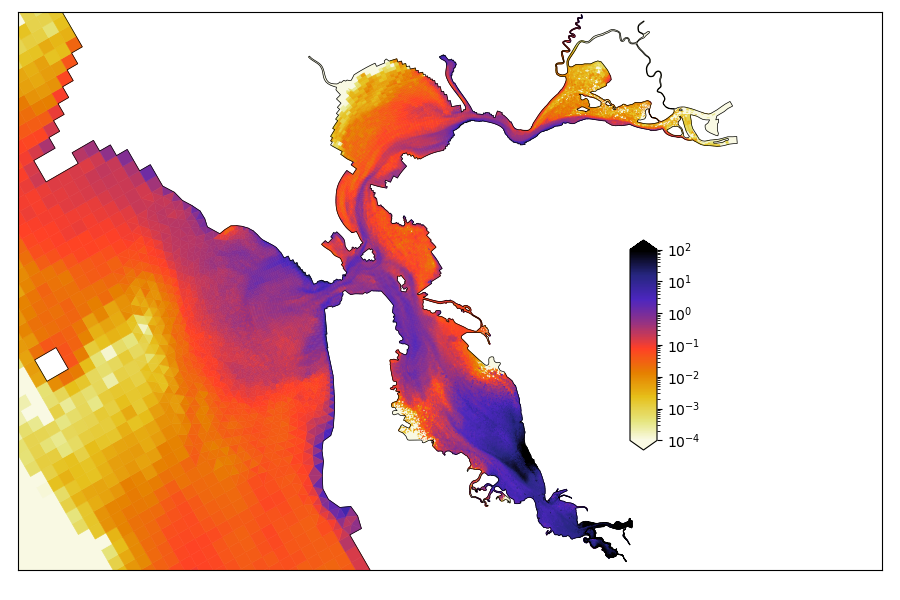

In [111]:
# trying to replicate the previous plots as a 
# sanity check
#fig=plt.figure(figsize=(12,7))
#ax=fig.add_subplot(1,1,1)

grid=unstructured_grid.UnstructuredGrid.from_ugrid(ds)

fig,ax=plt.subplots(1,1,figsize=(9,6))

cax_loc=[0.7,0.25,0.03,0.35]
cax=fig.add_axes(cax_loc)

cell_2dconc=ds.conc2d.values

clim=[1e-4,100]
ccoll=grid.plot_cells(values=cell_2dconc.clip(clim[0]),
                      cmap=cmap,norm=LogNorm(vmin=clim[0],vmax=clim[1],clip=True),
                      lw=0.4,edgecolor='face',ax=ax)
ax.axis('equal')
ax.axis( (517521., 609000., 4139744., 4230000.))
ax.xaxis.set_visible(0)
ax.yaxis.set_visible(0)
cbar=plt.colorbar(ccoll,cax=cax,extend='both')

plot_wkb.plot_wkb(ptm_set.poly(),ax=ax,lw=0.5,facecolor='none',edgecolor='k',zorder=3)

fig.subplots_adjust(left=0.02,right=0.98,top=0.98,bottom=0.05)


In [141]:
class BayConcFigure(object):
    figsize=(8.4,8)
    ax=None
    fig=None
    vmin=1e-4
    vmax=100.0
    zoom=(517521., 609000., 4139744., 4230000.)
    cmap=cmap
    cax_loc=[0.7,0.25,0.03,0.35]
    txt_loc=[0.65,0.7] # in ax coords
    cbar_label="Particles/m$^2$"
    cbar_args={} # don't modify - replace.
    draw_boundary=True
    fontsize=14
    extra_text=[]
    grid=None
    grid_poly=None
    num=None
    
    def __init__(self,ds,**kw):
        utils.set_keywords(self,kw)
        self.ds=ds
        if self.grid is None:
            self.grid=unstructured_grid.UnstructuredGrid.from_ugrid(ds)
        if self.grid_poly is None:
            self.grid_poly=self.grid.boundary_polygon()
            
        conc=self.ds['conc'].values

        if self.fig is None:
            self.fig=plt.figure(figsize=self.figsize,num=self.num)
        if self.ax is None:
            self.ax=self.fig.add_subplot(1,1,1)
        
        self.ccoll=grid.plot_cells(values=conc.clip(self.vmin,self.vmax),
                                   cmap=self.cmap,norm=colors.LogNorm(vmin=self.vmin,vmax=self.vmax),
                                   edgecolor='face',lw=0.4,ax=self.ax)
        if self.draw_boundary:
            self.boundary=plot_wkb.plot_wkb(self.grid_poly,ax=self.ax,ec='k',lw=0.5,fc='none')
        if self.cax_loc is not None:
            self.cax=self.fig.add_axes(self.cax_loc) # Need refactor
            plt.colorbar(self.ccoll,cax=self.cax,label=self.cbar_label,extend='both',
                         **self.cbar_args)
        self.ax.axis('equal')
        self.ax.axis(self.zoom)
        self.ax.xaxis.set_visible(0)
        self.ax.yaxis.set_visible(0)
        self.fig.subplots_adjust(left=0.01,right=0.99,top=0.99,bottom=0.01)
        
        self.add_labels()
        
    def __del__(self):
        try:
            self.ds.close()
        except AttributeError:
            pass
    def add_labels(self):
        texts=self.behavior_label()
        texts+=self.average_label()
        texts+=self.date_label()
        texts+=self.age_label()
        texts+=self.extra_text
        self.ax.text(self.txt_loc[0],self.txt_loc[1],"\n".join(texts),
                     fontsize=self.fontsize,va='top',ha='left',transform=self.ax.transAxes)
    def behavior_label(self):
        # go from a list of groups to a label
        grp_filter=self.ds.conc.attrs['grp_filter']
        if grp_filter not in ["","none"]:
            return [self.ds.conc.attrs['grp_filter']]
        else:
            return []
        #if behavior=='none':
        #    label='Passive'
        #elif behavior.startswith('up'):
        #    w_mmps=float(behavior.replace('up',''))/1000.0
        #    label=f'Rise {w_mmps:.1f} mm/s'
        #elif behavior.startswith('down'):
        #    w_mmps=float(behavior.replace('down',''))/1000.0
        #    label=f'Settle {w_mmps:.1f} mm/s'
    def age_label(self):
        return [ 
            "Max age: %d days"%(self.ds.conc.attrs['max_age']/np.timedelta64(1,'D')) 
             ]    
    def date_label(self):
        return [self.date_label_ext(self.ds)]
    @classmethod
    def date_label_ext(cls,ds):
        t_start=ds.conc.attrs['t_start']
        t_stop =ds.conc.attrs['t_stop']
        
        def fmt_t(t): return utils.to_datetime(t).strftime('%Y-%m-%d')
        return f"{fmt_t(t_start)} – {fmt_t(t_stop)}"
    
    def average_label(self):
        return [self.average_label_ext(self.ds)]
    
    @classmethod
    def average_label_ext(cls,ds):
        if ds.conc.attrs['z_filter']=='bed':
            return "Near bed"
        elif ds.conc.attrs['z_filter']=='surf':
            return "Near surface"
        elif ds.conc.attrs['z_filter']=='all':
            return "Full depth"
        else:
            return "Vertical range: %s"%(ds.conc.attrs['z_filter'])

# Same idea but settings for coastal region.
# note that with the 15 day output, these get truncated
# and show little action in the ocean.
class CoastalConcFigure(BayConcFigure):
    figsize=(7,8.1)
    zoom=(345000., 613202., 4050000., 4230105.)
    cax_loc=[0.05,0.20,0.03,0.35]
    txt_loc=[0.05,0.13] # in ax coords
    

<IPython.core.display.Javascript object>


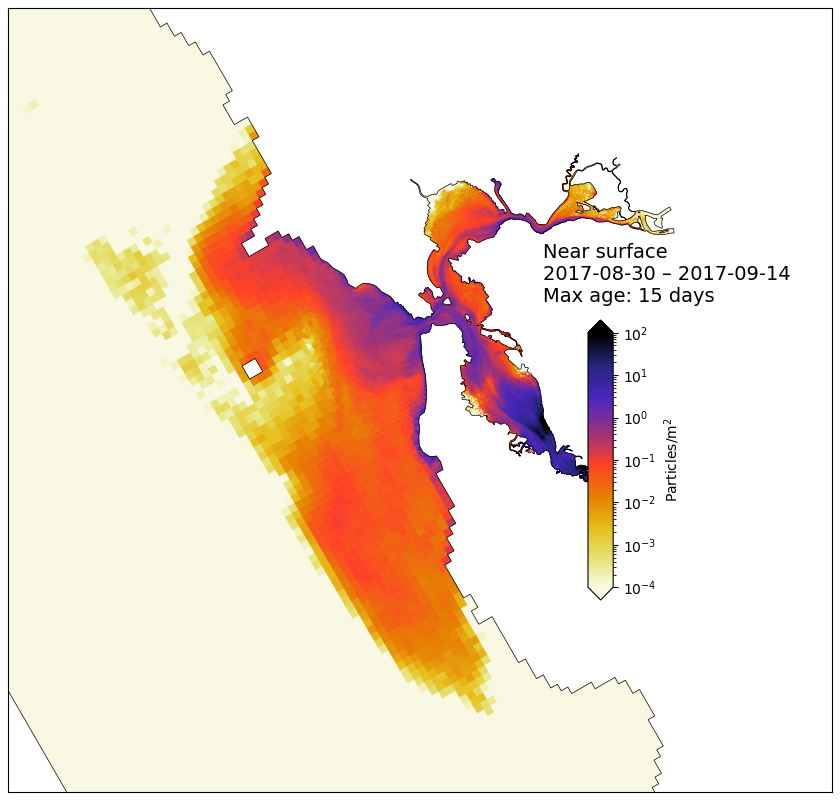

In [142]:
BayConcFigure(ds,grid=ptm_set.grid(),grid_poly=ptm_set.poly())

In [288]:
# These plots roughly duplicate what went into the report
display=False
force=False

if not display: plt.ioff()

for t_start in [np.datetime64('2017-08-30'),
                np.datetime64('2018-03-02') ]:
    t_stop=t_start+np.timedelta64(15,'D')
    for layer in ['surf','bed']:

        ds=ptm_set.
for ptm_conc in single_fns():
    ds=None
    conc=None
    for config in ['bay','coast']:
        img_fn=ptm_conc.replace('.nc',f'-{config}.png')
        
        if (not display) and os.path.exists(img_fn) and not force: 
            log.info(f"{img_fn}: exists")
            continue
        log.info(f"{img_fn}: processing")
        if ds is None:
            ds=xr.open_dataset(ptm_conc)
        if conc is None:
            conc=smooth(ds.conc.values)
        if config=='bay':
            bf=BayConcFigure(ds,conc=conc)
        elif config=='coast':
            bf=CoastalConcFigure(ds,conc=conc)
        else:
            raise Exception(f"Bad config {config}")
        if display:
            break
        bf.fig.savefig(img_fn,dpi=150)
        plt.close(bf.fig)
    
if not display: plt.ion()

INFO:root:processed/20170730_20170814/-0.0005/particles-avg-15days-v08nofiber-bay.png: processing
INFO:root:processed/20170730_20170814/-0.0005/particles-avg-15days-v08nofiber-coast.png: processing
INFO:root:processed/20170730_20170814/-0.0005/particles-avg-15days-v08std-bay.png: processing
INFO:root:processed/20170730_20170814/-0.0005/particles-avg-15days-v08std-coast.png: processing
INFO:root:processed/20170730_20170814/-0.0005/particles-bed-15days-v08nofiber-bay.png: processing
INFO:root:processed/20170730_20170814/-0.0005/particles-bed-15days-v08nofiber-coast.png: processing
INFO:root:processed/20170730_20170814/-0.0005/particles-bed-15days-v08std-bay.png: processing
INFO:root:processed/20170730_20170814/-0.0005/particles-bed-15days-v08std-coast.png: processing
INFO:root:processed/20170730_20170814/-0.0005/particles-surf-15days-v08nofiber-bay.png: processing
INFO:root:processed/20170730_20170814/-0.0005/particles-surf-15days-v08nofiber-coast.png: processing
INFO:root:processed/2017

In [293]:
display=False
if not display: plt.ioff()

for ptm_concA in combined_fns():
    for config in ['bay','coast']:
        img_fn=re.sub('(v\d\d)A',r'\1AB',ptm_concA).replace('.nc',f'-{config}.png')
    
        if (not display) and os.path.exists(img_fn): 
            log.info(f"{img_fn}: exists")
            continue
        log.info(f"{img_fn}: processing")
        ds,conc=load_combined(ptm_concA)
        if ds is None:
            continue
        kw=dict(extra_text=['44 day cutoff'])
        if config=='bay':
            bf=BayConcFigure(ds,conc=conc,txt_loc=[0.65,0.75],**kw)
        elif config=='coast':
            bf=CoastalConcFigure(ds,conc=conc,**kw)
        else:
            raise Exception(f"Bad config {config}")
        if not display:
            bf.fig.savefig(img_fn,dpi=150)
            plt.close(bf.fig)
    if display:
        break
    
if not display: plt.ion()

INFO:root:processed/20170828_20170911/-0.0005/particles-avg-44days-v08ABnofiber-bay.png: processing
INFO:root:processed/20170828_20170911/-0.0005/particles-avg-44days-v08ABnofiber-coast.png: processing
INFO:root:processed/20170828_20170911/-0.0005/particles-avg-44days-v08ABstd-bay.png: processing
INFO:root:processed/20170828_20170911/-0.0005/particles-avg-44days-v08ABstd-coast.png: processing
INFO:root:processed/20170828_20170911/-0.0005/particles-bed-44days-v08ABnofiber-bay.png: processing
INFO:root:processed/20170828_20170911/-0.0005/particles-bed-44days-v08ABnofiber-coast.png: processing
INFO:root:processed/20170828_20170911/-0.0005/particles-bed-44days-v08ABstd-bay.png: processing
INFO:root:processed/20170828_20170911/-0.0005/particles-bed-44days-v08ABstd-coast.png: processing
INFO:root:processed/20170828_20170911/-0.0005/particles-surf-44days-v08ABnofiber-bay.png: processing
INFO:root:processed/20170828_20170911/-0.0005/particles-surf-44days-v08ABnofiber-coast.png: processing
INFO

INFO:root:processed/20170828_20170911/0.0005/particles-bed-44days-v08ABstd-coast.png: processing
INFO:root:processed/20170828_20170911/0.0005/particles-surf-44days-v08ABnofiber-bay.png: processing
INFO:root:processed/20170828_20170911/0.0005/particles-surf-44days-v08ABnofiber-coast.png: processing
INFO:root:processed/20170828_20170911/0.0005/particles-surf-44days-v08ABstd-bay.png: processing
INFO:root:processed/20170828_20170911/0.0005/particles-surf-44days-v08ABstd-coast.png: processing
INFO:root:processed/20170828_20170911/0.005/particles-avg-44days-v08ABnofiber-bay.png: processing
INFO:root:processed/20170828_20170911/0.005/particles-avg-44days-v08ABnofiber-coast.png: processing
INFO:root:processed/20170828_20170911/0.005/particles-avg-44days-v08ABstd-bay.png: processing
INFO:root:processed/20170828_20170911/0.005/particles-avg-44days-v08ABstd-coast.png: processing
INFO:root:processed/20170828_20170911/0.005/particles-bed-44days-v08ABnofiber-bay.png: processing
INFO:root:processed/2

In [294]:
class MissingFiles(Exception): pass

class WsPanels(object):
    all_w_s=["-0.05","-0.005","-0.0005",
             "0.0",
             "0.0005","0.005","0.05"]
    figsize=(8.4,8)
    num=None
    PlotClass=BayConcFigure
    shape=(3,3)
    # weird python rules - tries to make this an instance method.
    panel_labeler=staticmethod(lambda i: "abcdefghijkl"[i])
    # for text label in each panel
    panel_txt_loc=[0.45,0.73]
    
    def loader(self,ptm_conc):
        return load_ptm_conc(ptm_conc)
    
    @classmethod
    def expand_ptm_conc(cls,ptm0_conc):
        ptm_concs=[ptm0_conc.replace("/0.0/","/"+w_s+"/")
                   for w_s in cls.all_w_s]
        if not all([os.path.exists(fn) for fn in ptm_concs]):
            log.warning("{ptm_conc} did not have all w_s - skip")
            raise MissingFiles()
        return ptm_concs
    
    def __init__(self,ptm0_conc,**kw):
        """
        ptm0_conc: path to the w_s=0.0 netcdf file.
        assumes that /0.0/ appears in the path, and
        can be replaced by the other settling velocities
        """
        utils.set_keywords(self,kw)
        
        ptm_concs=self.expand_ptm_conc(ptm0_conc)
        
        if self.num is not None:
            fig=plt.figure(figsize=self.figsize,num=self.num)
            fig.clf()
            fig.set_size_inches(self.figsize,forward=True)            
        self.fig,self.axs=plt.subplots(self.shape[0],self.shape[1],
                                       num=self.num,figsize=self.figsize)
        
        self.bfs=[]
        sum_conc=0.0
        for w_s,ptm_conc,ax in zip(self.all_w_s+['sum'],
                                   ptm_concs+['sum'],
                                   self.axs.ravel()):
            kw={}
            # Monkeys!
            kw['average_label']=lambda: ""
            kw['date_label']=lambda: ""
            if ptm_conc!=ptm_concs[0]:
                kw['cax_loc']=None
            else:
                # kw['cax_loc']=[0.68,0.03,0.02,0.28]
                kw['cax_loc']=[0.68,0.13,0.30,0.02]
                kw['cbar_args']={'orientation':'horizontal'}
            kw['txt_loc']=self.panel_txt_loc
            kw['fontsize']=12

            if ptm_conc=='sum':
                conc=sum_conc
                kw['behavior_label']=lambda: "Sum"
            else:
                ds,conc=self.loader(ptm_conc)
                sum_conc = sum_conc + conc
            bf=self.PlotClass(ds,conc=conc,ax=ax,fig=self.fig,**kw)
            self.bfs.append(bf)
            
        self.fig.subplots_adjust(hspace=0.0,wspace=0.0)
        ax=self.axs.ravel()[-1]
        plt.setp(ax.spines.values(),visible=0)
        ax.xaxis.set_visible(0)
        ax.yaxis.set_visible(0)
        
        sum_txts=[bf.date_label_ext(bf.ds),
                  bf.average_label_ext(bf.ds)]
        ax.text(0.10,0.90,"\n".join(sum_txts),transform=ax.transAxes,
               va='top',fontsize=12)
        # This is to avoid overwriting the neighboring spines.
        ax.patch.set_facecolor('none')
        
        if self.panel_labeler is not None:
            self.label_panels(self.axs.ravel()[:8])
    panel_label_loc=[0.05,0.9]
    panel_label_kw={'va':'top','fontsize':12,'fontweight':'bold'}
    def label_panels(self,axs):
        for i,ax in enumerate(axs):
            txt=self.panel_labeler(i)
            ax.text(self.panel_label_loc[0],self.panel_label_loc[1],txt,
                    transform=ax.transAxes,**self.panel_label_kw)
        
class WsPanelsCoastal(WsPanels):
    panel_label_loc=[0.02,0.16]
    panel_txt_loc=[0.02,0.08]
    PlotClass=CoastalConcFigure

In [297]:
# 8-panel plots
# Bay and coast
# show each of the settling velocities, and a summation.

display=False
force=True

if not display: plt.ioff()

# starts with 15 day datasets -- pull passive, and generate the
# rest

# filter the original list down to just the passive
#fns=glob.glob('processed/201*_201*/0.0/particles*-vNN.nc')
#fns.sort()

for ptm_conc in single_fns():
    if "/0.0/" not in ptm_conc:
        continue    
    #if ('20170830' not in ptm_conc) and ('20180302' not in ptm_conc):
    #    print(f"TMP skip {ptm_conc}")
    #    continue
    for config in ['bay','coast']:
        img_fn=ptm_conc.replace("0.0/","").replace('.nc',f'-{config}-8panel.png')
        if (not display) and os.path.exists(img_fn) and not force: 
            log.info(f"{img_fn}: exists")
            continue
        log.info(f"{img_fn}: processing")
        if config=='coast':
            pf=WsPanelsCoastal(ptm_conc)
        else:
            pf=WsPanels(ptm_conc)
        if display:
            break
        pf.fig.savefig(img_fn,dpi=150)
        plt.close(pf.fig)
    if display:
        break
if not display: plt.ion()

INFO:root:processed/20170730_20170814/particles-avg-15days-v08nofiber-bay-8panel.png: processing
INFO:root:processed/20170730_20170814/particles-avg-15days-v08nofiber-coast-8panel.png: processing
INFO:root:processed/20170730_20170814/particles-avg-15days-v08std-bay-8panel.png: processing
INFO:root:processed/20170730_20170814/particles-avg-15days-v08std-coast-8panel.png: processing
INFO:root:processed/20170730_20170814/particles-bed-15days-v08nofiber-bay-8panel.png: processing
INFO:root:processed/20170730_20170814/particles-bed-15days-v08nofiber-coast-8panel.png: processing
INFO:root:processed/20170730_20170814/particles-bed-15days-v08std-bay-8panel.png: processing
INFO:root:processed/20170730_20170814/particles-bed-15days-v08std-coast-8panel.png: processing
INFO:root:processed/20170730_20170814/particles-surf-15days-v08nofiber-bay-8panel.png: processing
INFO:root:processed/20170730_20170814/particles-surf-15days-v08nofiber-coast-8panel.png: processing
INFO:root:processed/20170730_20170

In [62]:
# Combined, panels
display=False
force=True

if not display:
    plt.ioff()
else:
    plt.ion()
for ptm_concA in combined_fns():
    if "/0.0/" not in ptm_concA:
        continue
    if ('20170828' not in ptm_concA) and ('20180228' not in ptm_concA):
        print("TMP")
        continue
    
    for config in ['coast']: # ['bay','coast']:
        img_fn=re.sub(r'(v\d\d)A',r'\1AB',ptm_concA)
        img_fn=img_fn.replace("0.0/","").replace('.nc',f'-{config}-8panel.png')
    
        if (not display) and (not force) and os.path.exists(img_fn): 
            log.info(f"{img_fn}: exists")
            continue
        log.info(f"{img_fn}: processing")
        #ds,conc=load_combined(ptm_concA)
        kw=dict(extra_text=['44 day cutoff'])
        
        if config=='coast':
            pf=WsPanelsCoastal(ptm_concA,loader=load_combined)
        else:
            pf=WsPanels(ptm_concA,loader=load_combined)
        if display:
            break
        pf.fig.savefig(img_fn,dpi=150)
        plt.close(pf.fig)
    if display:
        break
if not display:
    plt.ion()
    

INFO:root:processed/20170828_20170911/particles-avg-44days-v07ABnofiber-coast-8panel.png: processing


TMP
TMP
TMP
TMP
TMP
TMP


INFO:root:processed/20170828_20170911/particles-avg-44days-v07ABstd-coast-8panel.png: processing
INFO:root:processed/20170828_20170911/particles-bed-44days-v07ABnofiber-coast-8panel.png: processing
INFO:root:processed/20170828_20170911/particles-bed-44days-v07ABstd-coast-8panel.png: processing
INFO:root:processed/20170828_20170911/particles-surf-44days-v07ABnofiber-coast-8panel.png: processing
INFO:root:processed/20170828_20170911/particles-surf-44days-v07ABstd-coast-8panel.png: processing
INFO:root:processed/20180228_20180314/particles-avg-44days-v07ABnofiber-coast-8panel.png: processing


TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP


INFO:root:processed/20180228_20180314/particles-avg-44days-v07ABstd-coast-8panel.png: processing
INFO:root:processed/20180228_20180314/particles-bed-44days-v07ABnofiber-coast-8panel.png: processing
INFO:root:processed/20180228_20180314/particles-bed-44days-v07ABstd-coast-8panel.png: processing
INFO:root:processed/20180228_20180314/particles-surf-44days-v07ABnofiber-coast-8panel.png: processing
INFO:root:processed/20180228_20180314/particles-surf-44days-v07ABstd-coast-8panel.png: processing


TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP


In [167]:
# Plot a sum, surface plot vs. the manta
manta_std=pd.read_csv('manta_summary-v01std.csv')
manta_nofiber=pd.read_csv('manta_summary-v01nofiber.csv')

split_fields=('SampleID','part_per_m2','part_per_m3','area_m2')
common_fields=('SampleID','SampleType','x','y','Season')
manta_combined=pd.merge(manta_std.loc[:, split_fields],
                        manta_nofiber.loc[:, split_fields],
                        left_on='SampleID',right_on='SampleID',
                        how='outer',suffixes=['_std','_nofiber'])
manta=pd.merge(manta_nofiber.loc[:,common_fields],
               manta_combined,
               left_on='SampleID',right_on='SampleID',how='outer')

assert np.all(np.where( ~( manta['area_m2_std'].isnull() | manta['area_m2_nofiber'].isnull()),
                        manta['area_m2_std']==manta['area_m2_nofiber'],
                        True))

area=np.where(manta['area_m2_std'].isnull(),
              manta['area_m2_nofiber'],
              manta['area_m2_std'])
manta['area_m2']=area
manta.head()

,SampleID,SampleType,x,y,Season,part_per_m2_std,part_per_m3_std,area_m2_std,part_per_m2_nofiber,part_per_m3_nofiber,area_m2_nofiber,area_m2
0,CB-4-Manta-21Aug2017,Trawl,550326.816800,4.197530e+06,Dry,0.029667,0.312288,2118.727190,0.001180,0.012421,2118.727190,2118.727190
1,CB4-Manta-16Nov2017,Trawl,550326.816800,4.197530e+06,Wet,NaN,NaN,NaN,0.579936,6.104594,1081.727744,1081.727744
2,CB5-Manta-16Nov2017,Trawl,552177.481202,4.188548e+06,Wet,NaN,NaN,NaN,0.178455,1.878478,1408.382016,1408.382016
3,CB5-Manta-22Aug2017,Trawl,552177.481202,4.188548e+06,Dry,NaN,NaN,NaN,0.040986,0.431429,1447.658557,1447.658557
4,CB5-Manta-5Nov2017,Trawl,552177.481202,4.188548e+06,Dry,0.299179,3.149252,1866.537295,0.030895,0.325211,1866.537295,1866.537295


In [275]:
manta_nofiber[ np.isnan(manta.x)]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,SampleID,volume_l,area_m2,count_preblank,lat,lon,SampleDate,Season,SampleType,Fiber Bundle,...,Fiber Bundle_adj,Fragment_adj,Foam_adj,Film_adj,Sphere_adj,count,part_per_m3,part_per_m2,x,y
55,SFBay9-18-Manta-18Sept2017,95427.733495,1004.502458,42,NaN,NaN,2017-09-18,Dry,Trawl,0.0,...,0.0,27.5,1.833333,3.0,7.0,39.333333,0.412179,0.039157,NaN,NaN


In [168]:
manta.loc[:, ['SampleID','area_m2'] ]

,SampleID,area_m2
0,CB-4-Manta-21Aug2017,2118.727190
1,CB4-Manta-16Nov2017,1081.727744
2,CB5-Manta-16Nov2017,1408.382016
3,CB5-Manta-22Aug2017,1447.658557
4,CB5-Manta-5Nov2017,1866.537295
5,CB6-Manta-16Nov2017,1326.730742
6,CB6-Manta-22Aug2017,863.231493
7,CB7-Manta-16Nov2017,2788.437712
8,CB7-Manta-22Aug2017,2222.848266
9,CB8-Manta-11Jan18,2971.853913


In [298]:
def scatter_and_skill(manta_good,conc_field,model_conc,fig_prefix=None):
    model_matches=[]
    for idx,rec in manta_good.iterrows():
        if np.isnan(rec['x']):
            c=-1
            print("Sample is missing coordinates")
            model_matches.append(np.nan)
        else:
            c=grid.select_cells_nearest( [rec['x'],rec['y']])
            model_matches.append(conc[c])
    manta_good=manta_good.copy()
    manta_good['model_conc']=model_matches
    manta_good=manta_good[ np.isfinite(manta_good.model_conc.values)]

    ds=xr.Dataset.from_dataframe(manta_good)

    metrics=data_comparison.calc_metrics(ds.model_conc,ds[conc_field])

    fig=plt.figure(figsize=(6,5))
    ax=fig.add_subplot(1,1,1)

    ax.loglog(manta_good[conc_field],
              manta_good['model_conc'],'g.')
    ax.set_xlabel('Observed (particles m$^{-2}$)')
    ax.set_ylabel('Predicted (particles m$^{-2}$)')

    for k in metrics:
        print(f"{k:15}: {metrics[k]: .4g}")
        
    if fig_prefix is not None:
        img_fn=fig_prefix+"-scatter.png"
        fig.savefig(img_fn)
        with open(fig_prefix+"-scatter.txt",'wt') as fp:
            for k in metrics:
                fp.write(f"{k:15}: {metrics[k]: .4g}\n")
            

sub_version=std
max_age=15
season=Wet
v08, Wet, and no match
v08, Wet, and no match
v08, Wet, and no match
season=Dry
Appears to be a valid combo: Dry processed/20170730_20170814/0.0/particles-avg-15days-v08std.nc
Appears to be a valid combo: Dry processed/20170730_20170814/0.0/particles-bed-15days-v08std.nc
Appears to be a valid combo: Dry processed/20170730_20170814/0.0/particles-surf-15days-v08std.nc
processed/20170730_20170814/0.0/particles-surf-15days-v08std.nc expanded to
processed/20170730_20170814/-0.05/particles-surf-15days-v08std.nc
processed/20170730_20170814/-0.005/particles-surf-15days-v08std.nc
processed/20170730_20170814/-0.0005/particles-surf-15days-v08std.nc
processed/20170730_20170814/0.0/particles-surf-15days-v08std.nc
processed/20170730_20170814/0.0005/particles-surf-15days-v08std.nc
processed/20170730_20170814/0.005/particles-surf-15days-v08std.nc
processed/20170730_20170814/0.05/particles-surf-15days-v08std.nc


<IPython.core.display.Javascript object>


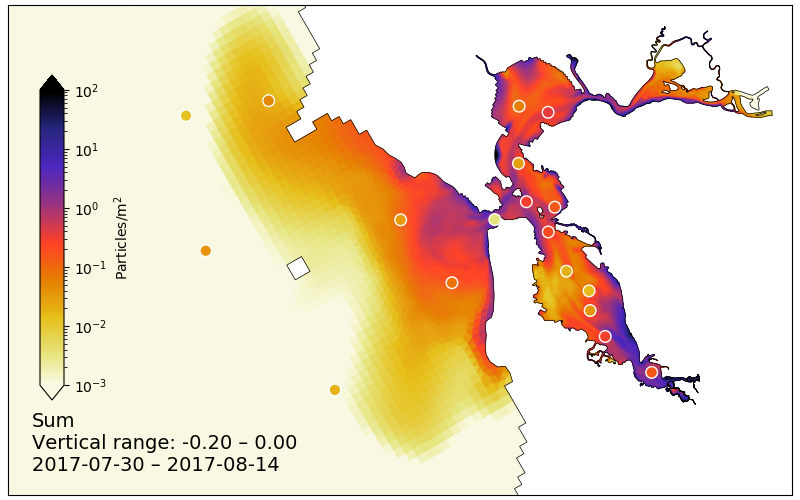

INFO:root:Saved image to processed/20170730_20170814/particles-surf-15days-v08std-coast-vs_manta-15days.png


<IPython.core.display.Javascript object>


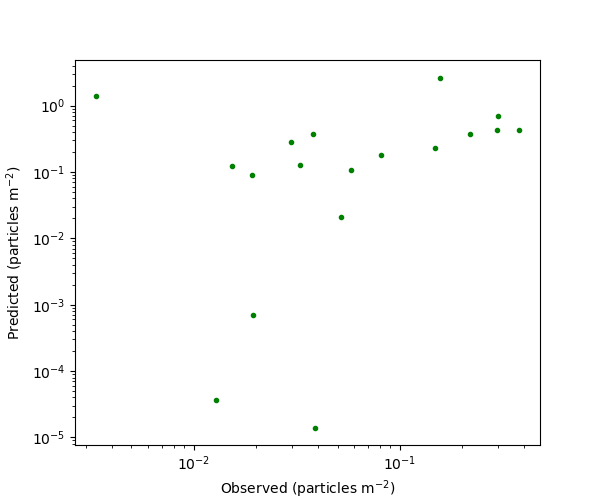

bias           :  0.2874
r              :  0.2034
amp            :  5.584
wilmott        :  0.1718
murphy         : -35.54
spearman_rho   :  0.3491
spearman_p     :  0.1429


max_age=44
season=Wet
v08, Wet, and no match
v08, Wet, and no match
v08, Wet, and no match
season=Dry
sub_version=nofiber
max_age=15
season=Wet
v08, Wet, and no match
v08, Wet, and no match
v08, Wet, and no match
season=Dry
Appears to be a valid combo: Dry processed/20170730_20170814/0.0/particles-avg-15days-v08nofiber.nc
Appears to be a valid combo: Dry processed/20170730_20170814/0.0/particles-bed-15days-v08nofiber.nc
Appears to be a valid combo: Dry processed/20170730_20170814/0.0/particles-surf-15days-v08nofiber.nc
processed/20170730_20170814/0.0/particles-surf-15days-v08nofiber.nc expanded to
processed/20170730_20170814/-0.05/particles-surf-15days-v08nofiber.nc
processed/20170730_20170814/-0.005/particles-surf-15days-v08nofiber.nc
processed/20170730_20170814/-0.0005/particles-surf-15days-v08nofiber.nc
processed/20170730_20170814/0.0/particles-surf-15days-v08nofiber.nc
processed/20170730_20170814/0.0005/particles-surf-15days-v08nofiber.nc
processed/20170730_20170814/0.005/particles

<IPython.core.display.Javascript object>


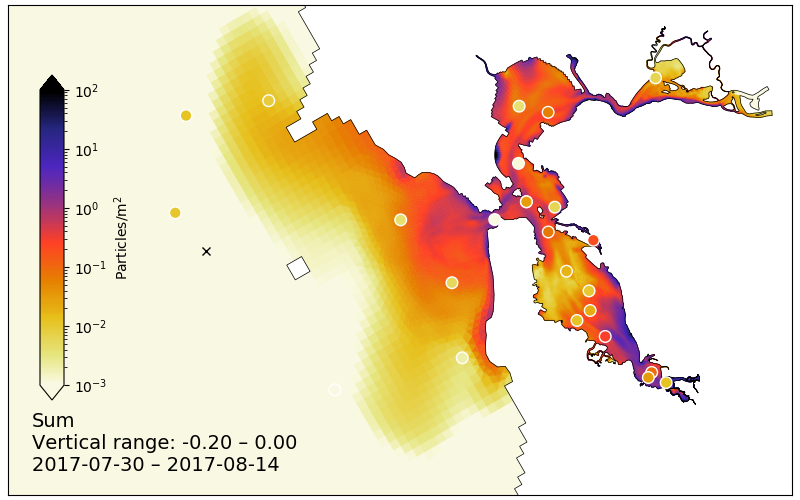

INFO:root:Saved image to processed/20170730_20170814/particles-surf-15days-v08nofiber-coast-vs_manta-15days.png


Sample is missing coordinates


<IPython.core.display.Javascript object>


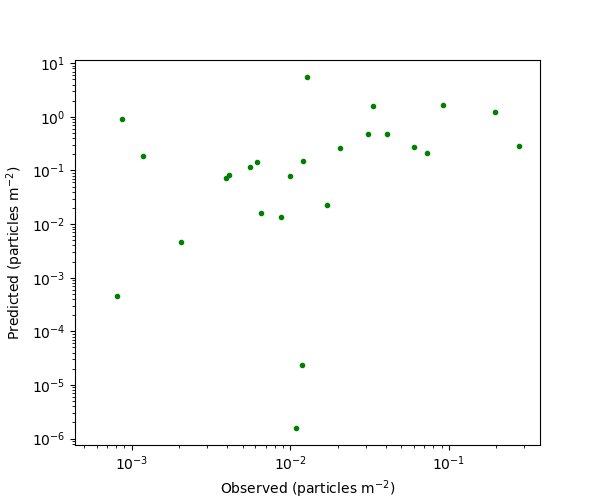

bias           :  0.4913
r              :  0.09928
amp            :  17.24
wilmott        :  0.0378
murphy         : -354.4
spearman_rho   :  0.609
spearman_p     :  0.0009607


max_age=44
season=Wet
v08, Wet, and no match
v08, Wet, and no match
v08, Wet, and no match
season=Dry


In [311]:
# So I want a sum concentration representative of wet weather.
# either 2/28 or 3/02.
# how the 2/28, 44 dayer.
display=False
force=True

for sub_version in ['std','nofiber']:
    print(f"sub_version={sub_version}")
    for max_age in [15,44]:
        print(f"max_age={max_age}")
        for season in ['Wet','Dry']:
            print(f"season={season}")
            # find the base ptm_conc
            kw={}
            if max_age==44:
                fns=combined_fns()
                loader=load_combined
                kw['extra_text']=['44 day cutoff']
            elif max_age==15:
                fns=single_fns()
                loader=load_ptm_conc
            else:
                raise Exception(f"Wha kind of max age is {max_age}")

            hit=False # did we find a good ptm_concA filename?
            for ptm_concA in fns:
                if "/0.0/" not in ptm_concA:
                    continue
                if sub_version not in ptm_concA:
                    continue
                if base_ver=='v07':
                    if ( (season=='Wet') and 
                         ('20180228' not in ptm_concA) and
                         ('20180302' not in ptm_concA) ):
                        continue
                    if ( (season=='Dry') and
                         ('20170828' not in ptm_concA) and
                         ('20170830' not in ptm_concA) ):
                        continue
                elif base_ver=='v08':
                    log.warning("Using a different dry month than before!")
                    if ( (season=='Wet') and 
                         ('20180228' not in ptm_concA) and
                         ('20180302' not in ptm_concA) ):
                        continue
                    if ( (season=='Dry') and
                         ('20170729' not in ptm_concA) and
                         ('20170730' not in ptm_concA) ):
                        continue
                else:
                    raise Exception(f"unknown base version {base_ver}")
                    
                if 'surf' not in ptm_concA:
                    continue

                config='coast'
                img_fn=ptm_concA
                if max_age>15: # i.e. it has A and B parts
                    img_fn=re.sub('(v\d\d)A',r'\1AB',ptm_concA) # .replace('vNNA','vNNAB45')
                img_fn=img_fn.replace("0.0/","").replace('.nc',f'-{config}-vs_manta-{max_age}days.png')

                if (not display) and (not force) and os.path.exists(img_fn): 
                    log.info(f"{img_fn}: exists")
                    continue
                hit=True
                break
            if not hit:
                continue
            # Get the full list of all settling velocities
            ptm_concs=WsPanels.expand_ptm_conc(ptm_concA)
            # Sum to get one concentration.
            conc=0.0
            for ptm_conc in ptm_concs:
                ds,conc_one=loader(ptm_conc)
                if ds is None:
                    print("Insufficient data - moving on")
                    conc=None
                    break
                conc=conc+conc_one
            if len(ptm_concs)==0 or (conc is None):
                continue
                
            fig,ax=plt.subplots(1,1,figsize=(8,5))

            F=CoastalConcFigure(ds,conc,vmin=1e-3,vmax=1e2,fig=fig,ax=ax,
                                behavior_label=lambda: "Sum",
                                txt_loc=[0.03,0.17],
                                cax_loc=[0.05,0.2,0.03,0.65])
            ax.axis('equal')
            # Plot the manta data.
            conc_field='part_per_m2_'+sub_version
            manta_sel=manta[ (manta.SampleType=='Trawl') 
                            & (manta.Season==season) 
                            & (~manta[conc_field].isnull())]
            bad=manta_sel[conc_field]<=0.0
            vmin=1e-3
            ax.scatter(manta_sel['x'][~bad],
                       manta_sel['y'][~bad],
                       70,
                       manta_sel[conc_field][~bad],
                       cmap=cmap, # Used to be 'CMRmap_r' which was wrong
                       edgecolors='w',
                       norm=colors.LogNorm(vmin=vmin,vmax=100),zorder=3)
            ax.plot(manta_sel['x'][bad],
                    manta_sel['y'][bad],
                    'kx')
            # Annotate what the typical minimum possible concentration is --
            # i.e. 1 particle in the whole sample volume.
            mdl=1./ np.median(manta.area_m2) # manta.volume_l/1000.
            if mdl>vmin:
                F.cax.axhline(mdl,color='k')
    
            ax.axis( (430820., 614360., 4119898., 4234611.) )
            fig.savefig(img_fn,dpi=150)
            log.info(f"Saved image to {img_fn}")
            
            if 1: # scatter and metrics
                scatter_and_skill(manta_sel[~bad],conc_field,conc,img_fn.replace('.png',''))
            if display: break
        if display: break
    if display:
        break
            

In [312]:
sed_std=pd.read_csv('sed_data_grouped-v01std.csv',index_col=0)
sed_nofiber=pd.read_csv('sed_data_grouped-v01nofiber.csv',index_col=0)

split_fields=('part_per_mass','part_per_mass_raw')
common_fields=('x','y')

sed_combined=pd.merge(sed_std.loc[:,split_fields],
                      sed_nofiber.loc[:,split_fields],
                      left_index=True,right_index=True,
                      how='outer',suffixes=['_std','_nofiber'])

sed=pd.merge(sed_std.loc[:,common_fields],sed_combined,
            left_index=True,right_index=True)
sed['name']=sed.index.values
sed.head()

,x,y,part_per_mass_std,part_per_mass_raw_std,part_per_mass_nofiber,part_per_mass_raw_nofiber,name
Central Bay,555693.0,4190807.0,2.791345,3.378813,1.565668,1.675333,Central Bay
Lower South Bay,581612.0,4148286.0,25.411375,28.760634,4.131815,5.599725,Lower South Bay
San Pablo Bay,553500.0,4213639.0,2.271236,2.893780,0.926732,1.152965,San Pablo Bay
South Bay,564992.0,4166840.0,1.120053,1.657012,0.306606,0.346021,South Bay
Southern Sloughs,587722.0,4144760.0,16.319796,21.652645,5.399812,6.602342,Southern Sloughs


In [142]:
utils.path("../field_data")
import plastic_data
sed_df=plastic_data.sediment_df
sed_df=sed_df[ sed_df['field_sample_p']]

grped=sed_df.groupby('SampleID')
lat=grped['ActualLatitude'].first()
lon=grped['ActualLongitude'].first()
ll=np.c_[lon,lat]
sed_xy=ll2utm(ll)

In [176]:
# for the new scatter plots for sediment, I want part_per_mass for each sample,
sed_samples=pd.read_csv('sed_samples-v01std.csv',index_col=0)

lat=sed_samples['lat']
lon=sed_samples['lon']
sed_sample_xy=ll2utm( np.c_[lon,lat] )
sed_samples['x']=sed_sample_xy[:,0]
sed_samples['y']=sed_sample_xy[:,1]


<IPython.core.display.Javascript object>


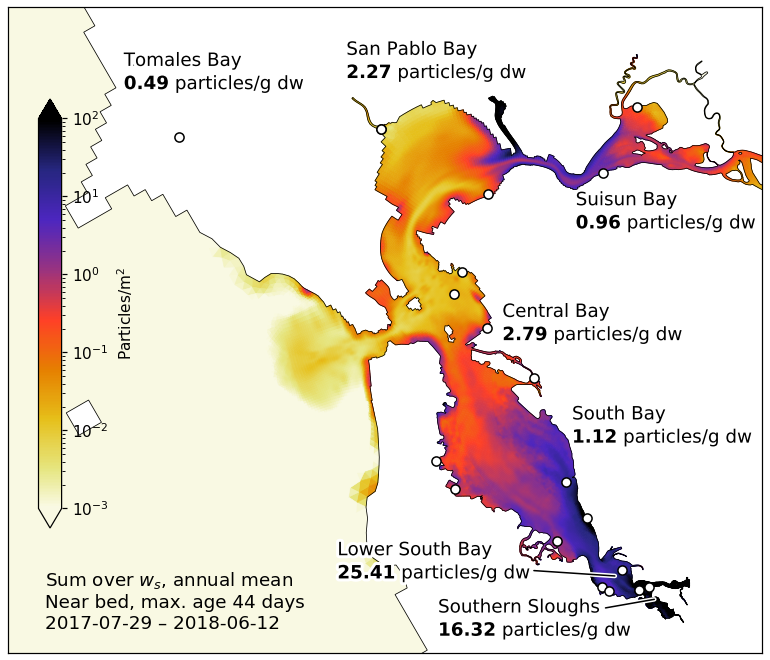

<IPython.core.display.Javascript object>


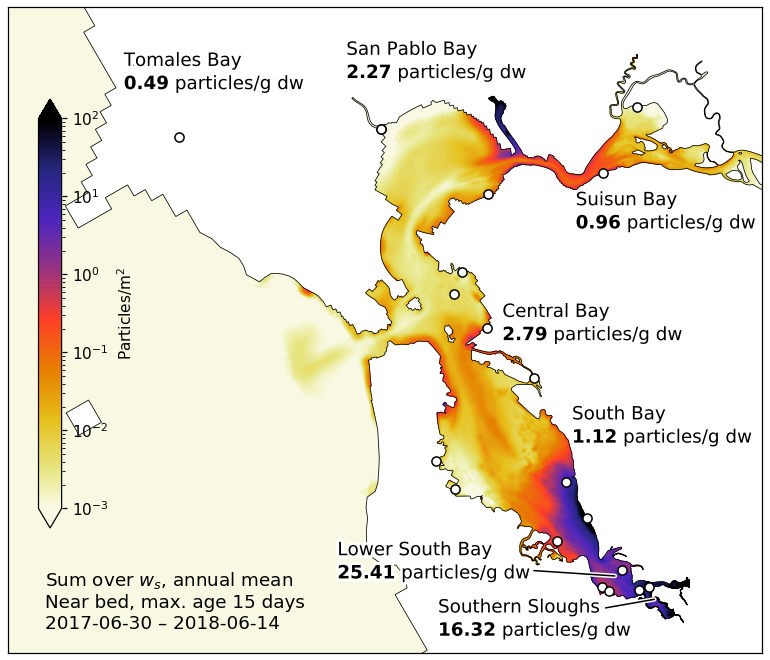

<IPython.core.display.Javascript object>


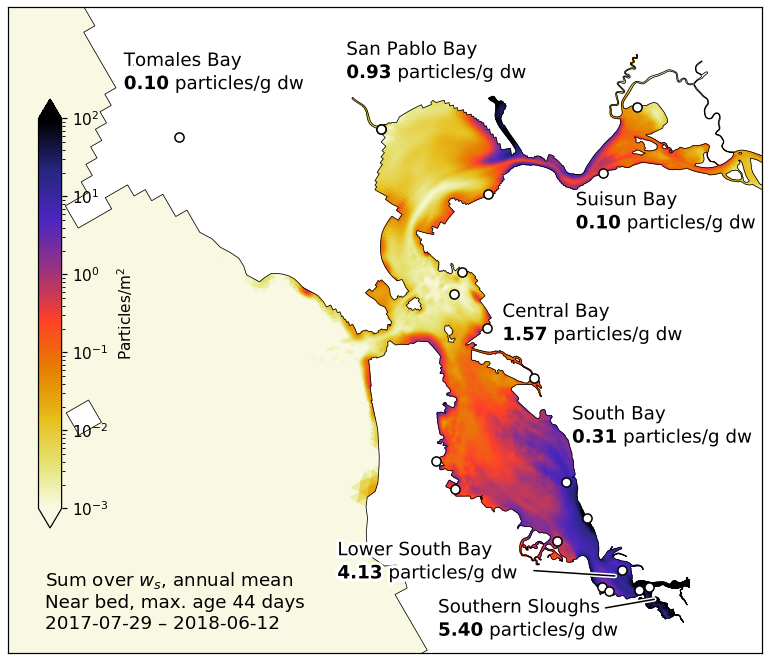

<IPython.core.display.Javascript object>


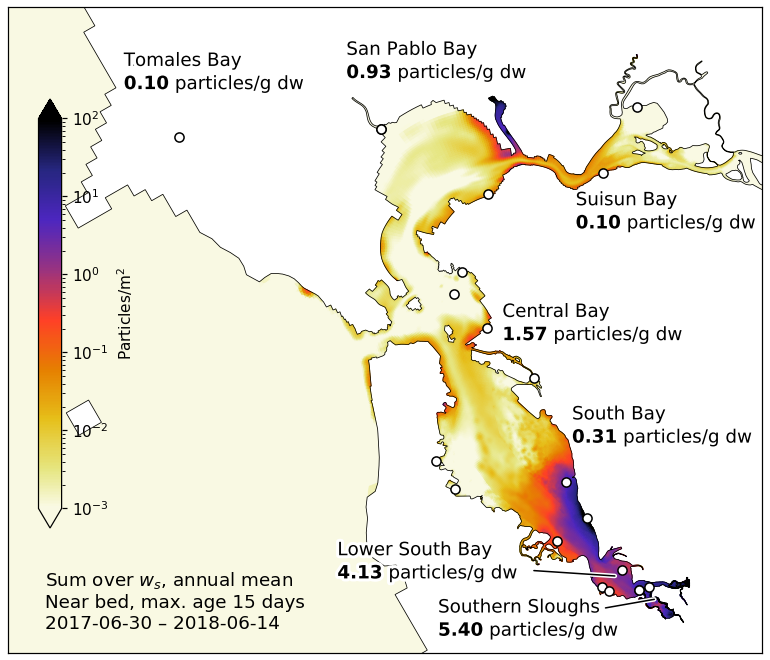

In [149]:
# average across all available.
display=True
force=True

if display: plt.ion()
else: plt.ioff()

for sub_version in ['std','nofiber']:
    for max_age in [44,15]:
        conc_accum=0.0 # accumulate concentrations for average.
        Naccum=0 # count how many fields have been added in here.

        t_min=None
        t_max=None

        # find the base ptm_conc
        if max_age==44:
            fns=combined_fns()
            loader=load_combined
        else:
            fns=single_fns()
            loader=load_ptm_conc

        for ptm_concA in fns:
            if "/0.0/" not in ptm_concA:
                continue
            if 'bed' not in ptm_concA:
                continue
            if sub_version not in ptm_concA:
                continue

            # Get the full list of all settling velocities
            ptm_concs=WsPanels.expand_ptm_conc(ptm_concA)
            # Sum to get one concentration.
            conc_sum=0.0
            for ptm_conc in ptm_concs:
                ds,conc_one=loader(ptm_conc)
                conc_sum=conc_sum+conc_one
                if t_min is None or t_min>ds.time_start:
                    t_min=ds.time_start
                if t_max is None or t_max<ds.time_end:
                    t_max=ds.time_end
            conc_accum=conc_accum+conc_sum
            Naccum+=1

            # grab the config naming while we have the filename
            model_data_label=re.sub(r'.*-(v.*)\.nc',r'\1',ptm_concA)

        conc_mean = conc_accum / Naccum
        ds=ds.copy()
        ds['time_start']=(),t_min
        ds['time_end']=(),t_max

        img_fn=f"processed/sediment-bed-{model_data_label}-{config}-{max_age}days.png"

        if (not display) and (not force) and os.path.exists(img_fn): 
            log.info(f"{img_fn}: exists")
            continue

        else:
            fns=single_fns()
            loader=load_ptm_conc

        for ptm_concA in fns:
            if "/0.0/" not in ptm_concA:
                continue
            if 'bed' not in ptm_concA:
                continue
            if sub_version not in ptm_concA:
                continue

            # Get the full list of all settling velocities
            ptm_concs=WsPanels.expand_ptm_conc(ptm_concA)
            # Sum to get one concentration.
            conc_sum=0.0
            for ptm_conc in ptm_concs:
                ds,conc_one=loader(ptm_conc)
                conc_sum=conc_sum+conc_one
                if t_min is None or t_min>ds.time_start:
                    t_min=ds.time_start
                if t_max is None or t_max<ds.time_end:
                    t_max=ds.time_end
            conc_accum=conc_accum+conc_sum
            Naccum+=1

            # grab the config naming while we have the filename
            model_data_label=re.sub(r'.*-(v.*)\.nc',r'\1',ptm_concA)

        conc_mean = conc_accum / Naccum
        ds=ds.copy()
        ds['time_start']=(),t_min
        ds['time_end']=(),t_max

        img_fn=f"processed/sediment-bed-{model_data_label}-{config}-{max_age}days.png"

        if (not display) and (not force) and os.path.exists(img_fn): 
            log.info(f"{img_fn}: exists")
            continue

        F=CoastalConcFigure(ds,conc_mean,vmin=1e-3,vmax=1e2,
                            behavior_label=lambda: "Sum over $w_s$, annual mean",
                            average_label=lambda: f"Near bed, max. age {max_age} days",
                            figsize=(7,6),
                            cax_loc=[0.05,0.2,0.03,0.65],
                            fontsize=12,
                            zoom=[487000., 604000., 4136255., 4237015.])

        if 1:
            # kludgy label postioning.
            sed['xoff']=0.0 ; sed['yoff']=0.0
            sed.loc['San Pablo Bay','yoff']=12000
            sed.loc['San Pablo Bay','xoff']=-6000 - 8000
            sed.loc['Suisun Bay','yoff']=-10000 - 4000
            sed.loc['Suisun Bay','xoff']=-15000 + 7000
            sed.loc['Central Bay','xoff']=18000 - 10000
            sed.loc['Central Bay','yoff']=-6000
            sed.loc['Tomales Bay','xoff']=6000 - 10000
            sed.loc['South Bay','yoff']=2000
            sed.loc['South Bay','xoff']=21000 - 11500
            sed.loc['Lower South Bay','xoff']=-18500 - 25000
            sed.loc['Lower South Bay','yoff']=-600
            sed.loc['Southern Sloughs','xoff']=-18000 - 16000
            sed.loc['Southern Sloughs','yoff']=-3000 - 3000

            # more kludge.  these map region labels to an optional
            #  callout line.  the coordinates are an offset from the text 
            #  location for the start of the line.  the end of the line
            #  is the dataset coordinates for the region (mean of sample locations).
            arrows={'Lower South Bay':[30e3,1.5e3],
                    'Southern Sloughs':[25.5e3,4.5e3]
            }
            
            conc_field='part_per_mass_'+sub_version
            for idx,row in sed.iterrows():
                F.ax.text(row['x']+row['xoff'],row['y']+row['yoff'],
                          f"{row['name']}\n$\mathbf{{ {row[conc_field]:.2f} }}$ particles/g dw",
                          fontsize=12,
                          path_effects=[pe.withStroke(linewidth=4, foreground="white")],
                          ha='left')
                if idx in arrows: # additionally add a callout arrow
                    axy=arrows[idx]
                    ann=F.ax.annotate("",
                                      xy=(row['x'],row['y']), xycoords='data',
                                      xytext=(axy[0]+row['x']+row['xoff'],
                                              axy[1]+row['y']+row['yoff']),
                                      textcoords='data',
                                      arrowprops=dict(arrowstyle="-",color='k',
                                                      connectionstyle="arc3"),
                                    )
                    ann.arrow_patch.set_path_effects([pe.Stroke(linewidth=3, foreground="w"),
                                                      pe.Normal()])
        if 1:
            # Show locations of individual samples
            F.ax.plot(sed_xy[:,0],sed_xy[:,1],
                      ls='none',marker='o',color='w',markeredgecolor='k')



        F.ax.axis(F.zoom)
        if not display:
            F.fig.savefig(img_fn,dpi=150)
            log.info(f"Saved image to {img_fn}")
        #if display: break
    #if display: break
        
if not display: plt.ion()


In [223]:
# average across all available.

@memoize.memoize(lru=20)
def load_cumulative(sub_version,max_age):
    conc_accum=0.0 # accumulate concentrations for average.
    Naccum=0 # count how many fields have been added in here.

    t_min=None
    t_max=None

    # find the base ptm_conc
    if max_age==44:
        fns=combined_fns()
        loader=load_combined
    else:
        fns=single_fns()
        loader=load_ptm_conc

    for ptm_concA in fns:
        if "/0.0/" not in ptm_concA:
            continue
        if 'bed' not in ptm_concA:
            continue
        if sub_version not in ptm_concA:
            continue

        # Get the full list of all settling velocities
        ptm_concs=WsPanels.expand_ptm_conc(ptm_concA)
        # Sum to get one concentration.
        conc_sum=0.0
        for ptm_conc in ptm_concs:
            ds,conc_one=loader(ptm_conc)
            conc_sum=conc_sum+conc_one
            if t_min is None or t_min>ds.time_start:
                t_min=ds.time_start
            if t_max is None or t_max<ds.time_end:
                t_max=ds.time_end
        conc_accum=conc_accum+conc_sum
        Naccum+=1

        # grab the config naming while we have the filename
        model_data_label=re.sub(r'.*-(v.*)\.nc',r'\1',ptm_concA)

    conc_mean = conc_accum / Naccum
    ds=ds.copy()
    ds['time_start']=(),t_min
    ds['time_end']=(),t_max
    ds['model_data_label']=(),model_data_label
    return ds,conc
    

<IPython.core.display.Javascript object>


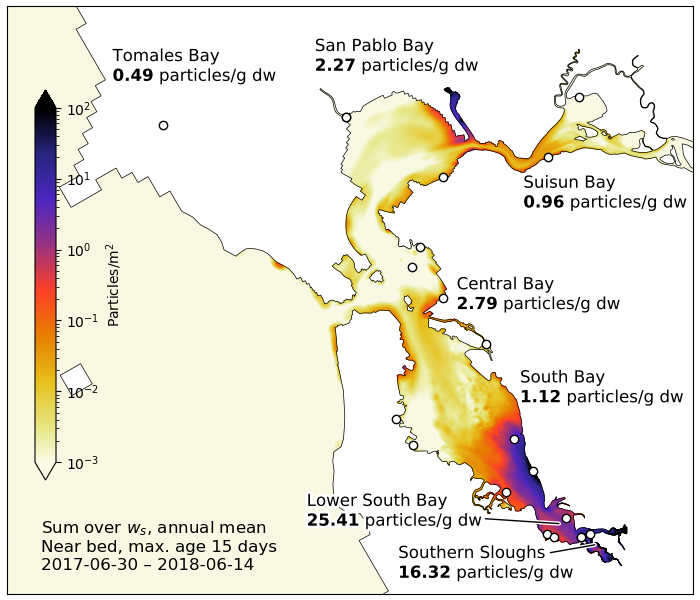

In [224]:
# refactored version of the cell colors vs. text labels
display=True
force=True

if display: plt.ion()
else: plt.ioff()

sub_versions=['std'] # ,'nofiber']
max_ages=[15] # [44,15]

for sub_version in sub_versions:
    for max_age in max_ages:
        ds,conc=load_cumulative(sub_version,max_age)

        model_data_label=ds['model_data_label'].item()
        img_fn=f"processed/sediment-bed-{model_data_label}-{config}-{max_age}days-v2.png"

        if (not display) and (not force) and os.path.exists(img_fn): 
            log.info(f"{img_fn}: exists")
            continue

        F=CoastalConcFigure(ds,conc_mean,vmin=1e-3,vmax=1e2,
                            behavior_label=lambda: "Sum over $w_s$, annual mean",
                            average_label=lambda: f"Near bed, max. age {max_age} days",
                            figsize=(7,6),
                            cax_loc=[0.05,0.2,0.03,0.65],
                            fontsize=12,
                            zoom=[487000., 604000., 4136255., 4237015.])

        if 1:
            # kludgy label postioning.
            sed['xoff']=0.0 ; sed['yoff']=0.0
            sed.loc['San Pablo Bay','yoff']=12000
            sed.loc['San Pablo Bay','xoff']=-6000 - 8000
            sed.loc['Suisun Bay','yoff']=-10000 - 4000
            sed.loc['Suisun Bay','xoff']=-15000 + 7000
            sed.loc['Central Bay','xoff']=18000 - 10000
            sed.loc['Central Bay','yoff']=-6000
            sed.loc['Tomales Bay','xoff']=6000 - 10000
            sed.loc['South Bay','yoff']=2000
            sed.loc['South Bay','xoff']=21000 - 11500
            sed.loc['Lower South Bay','xoff']=-18500 - 25000
            sed.loc['Lower South Bay','yoff']=-600
            sed.loc['Southern Sloughs','xoff']=-18000 - 16000
            sed.loc['Southern Sloughs','yoff']=-3000 - 3000

            # more kludge.  these map region labels to an optional
            #  callout line.  the coordinates are an offset from the text 
            #  location for the start of the line.  the end of the line
            #  is the dataset coordinates for the region (mean of sample locations).
            arrows={'Lower South Bay':[30e3,1.5e3],
                    'Southern Sloughs':[25.5e3,4.5e3]
            }
            
            conc_field='part_per_mass_'+sub_version
            for idx,row in sed.iterrows():
                F.ax.text(row['x']+row['xoff'],row['y']+row['yoff'],
                          f"{row['name']}\n$\mathbf{{ {row[conc_field]:.2f} }}$ particles/g dw",
                          fontsize=12,
                          path_effects=[pe.withStroke(linewidth=4, foreground="white")],
                          ha='left')
                if idx in arrows: # additionally add a callout arrow
                    axy=arrows[idx]
                    ann=F.ax.annotate("",
                                      xy=(row['x'],row['y']), xycoords='data',
                                      xytext=(axy[0]+row['x']+row['xoff'],
                                              axy[1]+row['y']+row['yoff']),
                                      textcoords='data',
                                      arrowprops=dict(arrowstyle="-",color='k',
                                                      connectionstyle="arc3"),
                                    )
                    ann.arrow_patch.set_path_effects([pe.Stroke(linewidth=3, foreground="w"),
                                                      pe.Normal()])
        if 1:
            # Show locations of individual samples
            F.ax.plot(sed_xy[:,0],sed_xy[:,1],
                      ls='none',marker='o',color='w',markeredgecolor='k')

        F.ax.axis(F.zoom)
        if not display:
            F.fig.savefig(img_fn,dpi=150)
            log.info(f"Saved image to {img_fn}")
        #if display: break
    #if display: break

In [234]:
# cell colors vs. text labels,
# now with the samples colored as well
# and.... drop the colored samples and the sample locations. just show
# the model.
display=False
force=True

if display: plt.ion()
else: plt.ioff()

sub_versions=['std'] # ,'nofiber']
max_ages=[15] # [44,15]

for sub_version in sub_versions:
    for max_age in max_ages:
        ds,conc=load_cumulative(sub_version,max_age)
        model_data_label=ds['model_data_label'].item()

        img_fn=f"processed/sediment-bed-{model_data_label}-{config}-{max_age}days-v3.png"

        if (not display) and (not force) and os.path.exists(img_fn): 
            log.info(f"{img_fn}: exists")
            continue

        F=CoastalConcFigure(ds,conc_mean,vmin=1e-3,vmax=1e2,
                            behavior_label=lambda: "Sum over $w_s$, annual mean",
                            average_label=lambda: f"Near bed, max. age {max_age} days",
                            figsize=(7,6),
                            # this changes for the colored samples
                            # shift right to allow double colorbar, and down
                            # since I'm dropping text box, too.
                            #cax_loc=[0.16,0.035,0.03,0.65], # for double cbar
                            cax_loc=[0.085,0.06,0.04,0.55],
                            fontsize=12,
                            zoom=[487000., 604000., 4136255., 4237015.])

        if 0:
            # kludgy label postioning.
            sed['xoff']=0.0 ; sed['yoff']=0.0
            sed.loc['San Pablo Bay','yoff']=12000
            sed.loc['San Pablo Bay','xoff']=-6000 - 8000
            sed.loc['Suisun Bay','yoff']=-10000 
            sed.loc['Suisun Bay','xoff']=-15000 + 7000
            sed.loc['Central Bay','xoff']=18000 - 10000
            sed.loc['Central Bay','yoff']=-2000
            sed.loc['Tomales Bay','xoff']=6000 - 5000
            sed.loc['Tomales Bay','yoff']=2000
            sed.loc['South Bay','yoff']=2000
            sed.loc['South Bay','xoff']=21000 - 11500
            sed.loc['Lower South Bay','xoff']=-18500 - 12000
            sed.loc['Lower South Bay','yoff']=-600
            sed.loc['Southern Sloughs','xoff']=-18000 - 16000
            sed.loc['Southern Sloughs','yoff']=-3000 

            # more kludge.  these map region labels to an optional
            #  callout line.  the coordinates are an offset from the text 
            #  location for the start of the line.  the end of the line
            #  is the dataset coordinates for the region (mean of sample locations).
            arrows={'Lower South Bay':[24e3,1.5e3],
                    'Southern Sloughs':[25.5e3,1.5e3]
            }
            
            conc_field='part_per_mass_'+sub_version
            for idx,row in sed.iterrows():
                txt=f"{row['name']}"
                if 0: # include data in the text
                    txt+=f"\n$\mathbf{{ {row[conc_field]:.2f} }}$ particles/g dw"
                F.ax.text(row['x']+row['xoff'],row['y']+row['yoff'],
                          txt,
                          fontsize=12,
                          path_effects=[pe.withStroke(linewidth=4, foreground="white")],
                          ha='left')
                if idx in arrows: # additionally add a callout arrow
                    axy=arrows[idx]
                    ann=F.ax.annotate("",
                                      xy=(row['x'],row['y']), xycoords='data',
                                      xytext=(axy[0]+row['x']+row['xoff'],
                                              axy[1]+row['y']+row['yoff']),
                                      textcoords='data',
                                      arrowprops=dict(arrowstyle="-",color='k',
                                                      connectionstyle="arc3"),
                                    )
                    ann.arrow_patch.set_path_effects([pe.Stroke(linewidth=3, foreground="w"),
                                                      pe.Normal()])
        if 0: # Show locations of individual samples
            F.ax.plot(sed_xy[:,0],sed_xy[:,1],
                      ls='none',marker='o',color='w',markeredgecolor='k')
        if 0: # Include colored scatter:
            if 0: # Scatter with individual samples colored by concentration.
                scaling=30
                scat=F.ax.scatter(sed_samples['x'],sed_samples['y'],100,
                                  sed_samples['part_per_mass'],
                                  cmap=cmap,
                                  edgecolors='w',
                                  norm=colors.LogNorm(vmin=vmin*scaling,vmax=100*scaling),zorder=3)
            if 1: # Scatter with sub-embayment levels colored
                scaling=30
                scat=F.ax.scatter(sed['x'],sed['y'],160,
                                  sed[conc_field],
                                  marker='s',
                                  cmap=cmap,
                                  edgecolors='w',
                                  norm=colors.LogNorm(vmin=vmin*scaling,vmax=100*scaling),zorder=3)
            # for scatters, make an offset colorbar. 
            cax2=F.fig.add_axes(F.cax_loc,label='extra')
            plt.colorbar(scat,cax2,extend='both',label='Particles/g dw')
            cax2.yaxis.set_ticks_position('left')
            cax2.yaxis.set_label_position('left')
            cax2.set_ylabel('Particles/g dw')

        # for a cleaner figure for presentation, drop extra text
        del F.ax.texts[0]
        F.ax.axis(F.zoom)
        if not display:
            F.fig.savefig(img_fn,dpi=150)
            log.info(f"Saved image to {img_fn}")
        #if display: break
    #if display: break

INFO:root:Saved image to processed/sediment-bed-v07std-coast-15days-v3.png


<IPython.core.display.Javascript object>


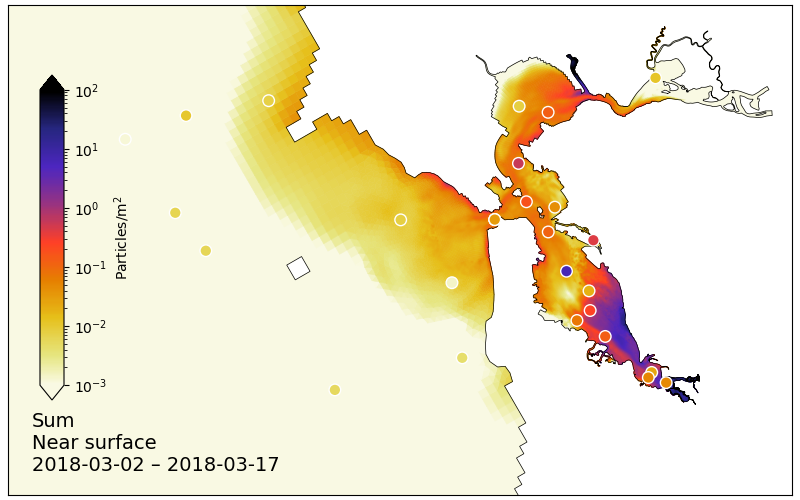

INFO:root:Saved image to processed/20180302_20180317/particles-surf-15days-v07nofiber-coast-vs_manta-15days-scatter.png


In [238]:
# Quantitative scatter plots
# Trawl data:


# So I want a sum concentration representative of wet weather.
# either 2/28 or 3/02.
# how the 2/28, 44 dayer.
display=True
force=True

for sub_version in ['nofiber']: # ['std','nofiber']:
    for max_age in [15]: # ,44]:
        for season in ['Wet']: # ['Wet','Dry']:
            # find the base ptm_conc
            kw={}
            if max_age==44:
                fns=combined_fns()
                loader=load_combined
                kw['extra_text']=['44 day cutoff']
            elif max_age==15:
                fns=single_fns()
                loader=load_ptm_conc
            else:
                raise Exception(f"Wha kind of max age is {max_age}")

            for ptm_concA in fns:
                if "/0.0/" not in ptm_concA:
                    continue
                if sub_version not in ptm_concA:
                    continue
                if ( (season=='Wet') and 
                     ('20180228' not in ptm_concA) and
                     ('20180302' not in ptm_concA) ):
                    continue
                if ( (season=='Dry') and 
                     ('20170828' not in ptm_concA) and
                     ('20170830' not in ptm_concA) ):
                    continue
                if 'surf' not in ptm_concA:
                    continue

                config='coast'
                img_fn=ptm_concA
                if max_age>15: # i.e. it has A and B parts
                    img_fn=re.sub('(v\d\d)A',r'\1AB',ptm_concA) # .replace('vNNA','vNNAB45')
                img_fn=img_fn.replace("0.0/","").replace('.nc',f'-{config}-vs_manta-{max_age}days-scatter.png')

                if (not display) and (not force) and os.path.exists(img_fn): 
                    log.info(f"{img_fn}: exists")
                    continue
                break
            # Get the full list of all settling velocities
            ptm_concs=WsPanels.expand_ptm_conc(ptm_concA)
            # Sum to get one concentration.
            conc=0.0
            for ptm_conc in ptm_concs:
                ds,conc_one=loader(ptm_conc)
                conc=conc+conc_one

            fig,ax=plt.subplots(1,1,figsize=(8,5))

            F=CoastalConcFigure(ds,conc,vmin=1e-3,vmax=1e2,fig=fig,ax=ax,
                                behavior_label=lambda: "Sum",
                                txt_loc=[0.03,0.17],
                                cax_loc=[0.05,0.2,0.03,0.65])
            ax.axis('equal')
            # Plot the manta data.
            conc_field='part_per_m2_'+sub_version
            manta_sel=manta[ (manta.SampleType=='Trawl') 
                            & (manta.Season==season) 
                            & (~manta[conc_field].isnull())]
            bad=manta_sel[conc_field]<=0.0
            vmin=1e-3
            ax.scatter(manta_sel['x'][~bad],
                       manta_sel['y'][~bad],
                       70,
                       manta_sel[conc_field][~bad],
                       cmap=cmap, # Used to be 'CMRmap_r' which was wrong
                       edgecolors='w',
                       norm=colors.LogNorm(vmin=vmin,vmax=100),zorder=3)
            ax.plot(manta_sel['x'][bad],
                    manta_sel['y'][bad],
                    'kx')
            # Annotate what the typical minimum possible concentration is --
            # i.e. 1 particle in the whole sample volume.
            mdl=1./ np.median(manta.area_m2) # manta.volume_l/1000.
            if mdl>vmin:
                F.cax.axhline(mdl,color='k')
    
            ax.axis( (430820., 614360., 4119898., 4234611.) )
            fig.savefig(img_fn,dpi=150)
            log.info(f"Saved image to {img_fn}")
            
            # The scatter part:
            
            
            if display: break
        if display: break
    if display:
        break
            

<IPython.core.display.Javascript object>


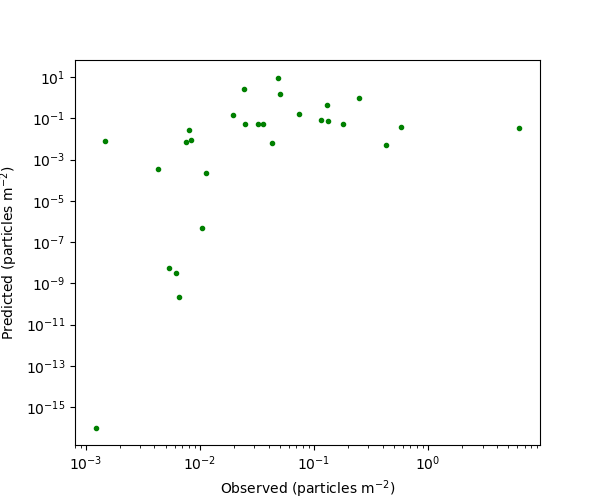

bias           :  0.2726
r              : -0.05983
amp            :  1.617
wilmott        :  0.03785
murphy         : -2.865
spearman_rho   :  0.5968
spearman_p     :  0.0006315


In [262]:
#manta_sel['x'][~bad], manta_sel['y'][~bad], manta_sel[conc_field][~bad],

scatter_and_skill(manta_sel[~bad],conc_field,conc)

<IPython.core.display.Javascript object>


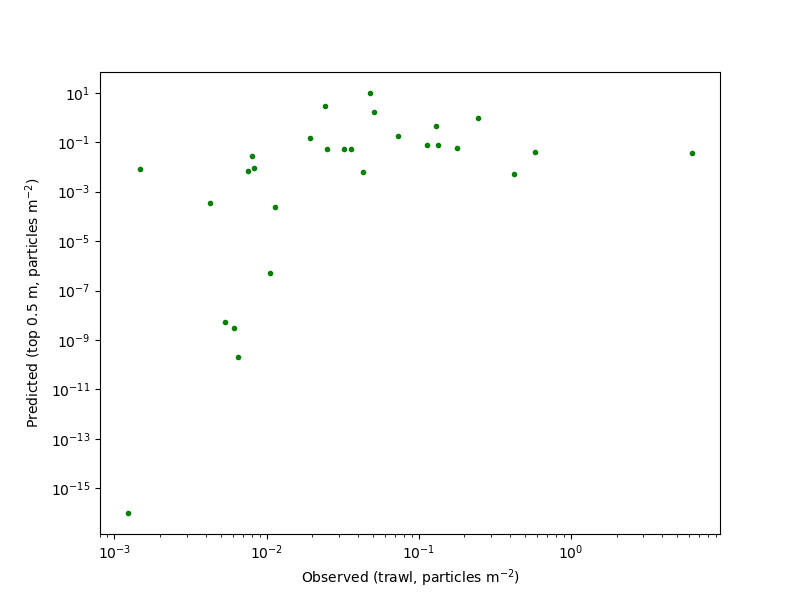

bias           :  0.2726
r              : -0.05983
amp            :  1.617
wilmott        :  0.03785
murphy         : -2.865
spearman_rho   :  0.5968
spearman_p     :  0.0006315


In [260]:
six.moves.reload_module(data_comparison)

metrics=data_comparison.calc_metrics(ds.model_conc,ds.part_per_m2_nofiber)

fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(1,1,1)

ax.loglog(manta_good[conc_field],
        manta_good['model_conc'],'g.')
ax.set_xlabel('Observed (trawl, particles m$^{-2}$)')
ax.set_ylabel('Predicted (top 0.5 m, particles m$^{-2}$)')

for k in metrics:
    print(f"{k:15}: {metrics[k]: .4g}")